<a href="https://colab.research.google.com/github/bmjaron/capstone/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
import string

#NLTK
import nltk
from nltk.collocations import *
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [55]:
username = input("Enter username:")

key = input("Enter API key:")

Enter username:
Enter API key:


In [3]:
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':f"{username}" ,
'key':f"{key}"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [4]:
import kaggle


In [5]:
!kaggle datasets download -d rmisra/news-category-dataset

 68% 18.0M/26.5M [00:00<00:00, 76.7MB/s]
100% 26.5M/26.5M [00:00<00:00, 93.6MB/s]


In [6]:
!unzip /content/news-category-dataset.zip

Archive:  /content/news-category-dataset.zip
  inflating: News_Category_Dataset_v3.json  


In [7]:
df = pd.read_json("/content/News_Category_Dataset_v3.json", lines=True)
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [8]:
df.shape

(209527, 6)

Our dataset contains roughly 210,000 news articles from Huffington Post.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [10]:
df['category'].value_counts().head()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
Name: category, dtype: int64

In [11]:
len(df['category'].value_counts())

42

# II. EDA

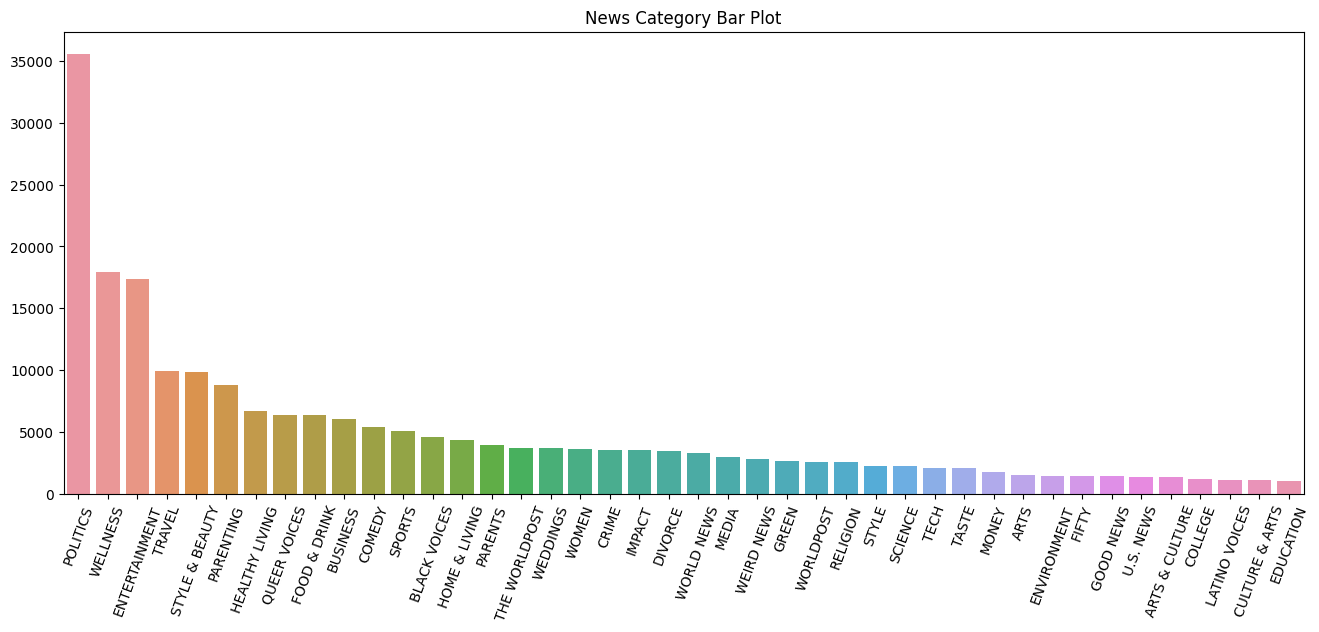

In [12]:
fig, ax = plt.subplots(figsize=(16,6))

#Barplot of different categories
sns.barplot(x=df['category'].value_counts().index,
            y=df['category'].value_counts().values)

plt.title("News Category Bar Plot")
#Rotate x-labels for visibility
plt.xticks(rotation=70);

# III. Two class classification

## A. Re-classifying Data

In [13]:
df_2c = df.copy()

In [14]:
#Convert every category into politics (1) or not politics (0)
df_2c['category'] = df_2c['category'].map(lambda x: 1 if x == 'POLITICS' else 0)



In [15]:
df_2c['category'].value_counts()

0    173925
1     35602
Name: category, dtype: int64

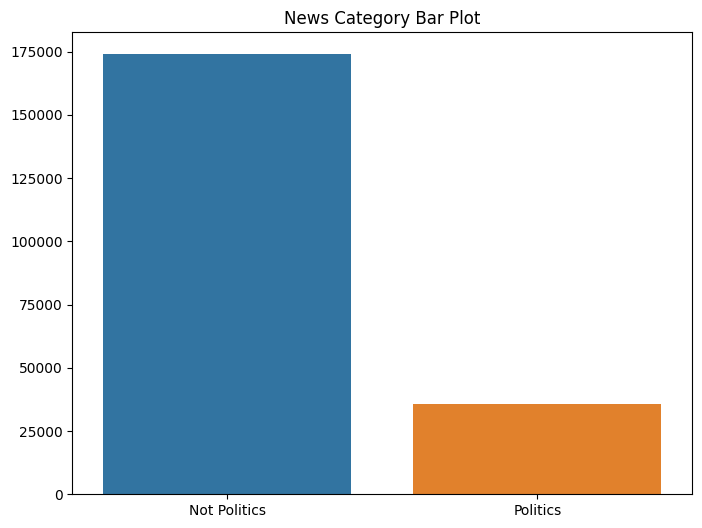

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

#Barplot of different categories
sns.barplot(x=['Not Politics', 'Politics'],
            y=df_2c['category'].value_counts().values)

plt.title("News Category Bar Plot");

There is still an incredible amount of imbalance, but we'll acount for this by randomly undersampling the majority class.

## B. Text Cleaning

Define a function to clean text.

In [17]:
def text_cleaning(text):
  #Lowercase
  text = text.lower()
  #Strip punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

  return text

In [18]:
#Map function on article descriptions
df_2c['short_description'] = df_2c['short_description'].map(lambda x: text_cleaning(x))

Tokenize the text.

In [19]:
#Map NLTK tokenizer on text
df_2c['short_description'] = df_2c['short_description'].map(lambda x: nltk.word_tokenize(x))

In [20]:
#Preview
df_2c[['short_description']].head()

,short_description
0,"[health, experts, said, it, is, too, early, to..."
1,"[he, was, subdued, by, passengers, and, crew, ..."
2,"[until, you, have, a, dog, you, dont, understa..."
3,"[accidentally, put, grownup, toothpaste, on, m..."
4,"[amy, cooper, accused, investment, firm, frank..."


Stopword removal

In [21]:
#Store English stopwords as object
stop_words = stopwords.words('english')

#Map thru and remove
df_2c['short_description'] = df_2c['short_description'].map(lambda x: [word for word in x if word not in stop_words])

In [22]:
df_2c[['short_description']].head()

,short_description
0,"[health, experts, said, early, predict, whethe..."
1,"[subdued, passengers, crew, fled, back, aircra..."
2,"[dog, dont, understand, could, eaten]"
3,"[accidentally, put, grownup, toothpaste, toddl..."
4,"[amy, cooper, accused, investment, firm, frank..."


In [23]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

df_2c['short_description'] = df_2c['short_description'].map(lambda x: [stemmer.stem(word) for word in x])

In [24]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

df_2c['short_description'] = df_2c['short_description'].map(lambda x: [wnl.lemmatize(word) for word in x])

## C. Histograms and More EDA

In [25]:
from nltk.probability import FreqDist

In [28]:
corpus_words = [word for desc in df_2c['short_description'] for word in desc]

In [29]:
FreqDist(corpus_words).most_common(20)

[('’', 13833),
 ('one', 13825),
 ('time', 11150),
 ('new', 10683),
 ('like', 10432),
 ('u', 10240),
 ('year', 10222),
 ('peopl', 9827),
 ('get', 9166),
 ('make', 9104),
 ('day', 8558),
 ('said', 7660),
 ('say', 7550),
 ('want', 7518),
 ('“', 6989),
 ('take', 6558),
 ('way', 6553),
 ('go', 6447),
 ('know', 6435),
 ('life', 6305)]

In [ ]:
non_politics_df = df_2c[df_2c['category'] == 0]
politics_df = df_2c[df_2c['category'] == 1]

#Non-politics words
non_politics_words = [word for desc in non_politics_df['short_description'] for word in desc]

unique_politics = []

for desc in politics_df['short_description']:
  for word in desc:
    if word not in non_politics_words:
      unique_politics.append(word)



In [ ]:
politics_fdist = FreqDist(unique_politics).most_common(20)
politics_fdist

## D. Initial Modeling

Split data into training, testing and holdout sets.

In [34]:
X = df_2c[['short_description']]
y = df_2c['category']

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=0)

#Spit train into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)

Synthetic undersampling of majority class.

In [40]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1, random_state=0)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Vectorize data to prepare for modeling.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
vectorizer = TfidfVectorizer()


In [49]:
X_train_rus_vectorized = X_train_rus['short_description'].map(lambda x: ' '.join(word for word in x))


X_vec = vectorizer.fit_transform(X_train_rus_vectorized)


In [54]:
X_train_rus_vectorized = pd.DataFrame(data = X_vec.toarray(),
                                      columns = vectorizer.get_feature_names_out())
X_train_rus_vectorized.index = X_train_rus['short_description']


Run a naive Bayes' classifier.